Description

In [1]:
import sys
sys.path.append('/lhome/ific/c/ccortesp/Analysis')

from libs import plotting_tools as pt

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image 
from scipy.optimize import curve_fit
from scipy.stats import linregress

# Styling Plot
pt.ccortesp_plot_style()
PRELIM_LOGO = np.asarray(Image.open('/lhome/ific/c/ccortesp/Analysis/images/next_logo_preliminary.png'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Preliminary

In [2]:
# RUN SELECTION
# RUN_IDS = [15589, 15590, 15591, 15593, 15594, 15596]
RUN_IDS = [15589]

# DIRECTORIES, PATHS & FILES
INPUT_DIR = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Th_analysis/h5/'

SUMMARY_FILENAME = "summary_Th_processing.csv"      # Choose your name
SUMMARY_PATH = os.path.join('/lhome/ific/c/ccortesp/Analysis/NEXT-100/Th_analysis/txt/', SUMMARY_FILENAME)

# KEYS
EVT_KEY = 'Events'
HIT_KEY = 'Hits'

# CUTFLOW
CUT_NAMES = ['IC', 'Cleaning', 'One_S1', 'One_S2', 'Electron_like', 'Processed']

# FIDUCIAL VOLUME DEFINITION
Z_LOW = 40          # in [mm], I use Z not DT
Z_UP  = 1147        # in [mm]
R_UP  = 450         # in [mm]

KNOWN_PEAKS_PES = {
                        "511 keV":   {'real_MeV': 0.511,  'guess': 1.05e5,  'range': (1e5, 1.09e5)},
                        "583 keV":   {'real_MeV': 0.583,  'guess': 1.2e5,  'range': (1.14e5, 1.24e5)},
                        "727 keV":   {'real_MeV': 0.727,  'guess': 1.5e5,  'range': (1.41e5, 1.56e5)},
                        "860 keV":   {'real_MeV': 0.860,  'guess': 1.77e5,  'range': (1.71e5, 1.84e5)},
                        "DE Peak":   {'real_MeV': 1.592,  'guess': 3.3e5,  'range': (3.23e5, 3.37e5)},
                        "Tl Peak":   {'real_MeV': 2.615,  'guess': 5.42e5,  'range': (5.34e5, 5.54e5)}
}

## Processed Data

In [3]:
all_event_dfs = []      # Event-level

for run_id in RUN_IDS:
    # ----- LDC Loop ----- #
    for ldc in range(1, 8):
        # Load the HDF5 file
        h5_path = os.path.join(INPUT_DIR, f'processed_run_{run_id}_ldc{ldc}.h5')
        if not os.path.exists(h5_path):
            print(f"Missing file for run {run_id} ldc {ldc}. Skipping...")
            continue

        try:
            evt_df = pd.read_hdf(h5_path, key=EVT_KEY)
            all_event_dfs.append(evt_df)

        except Exception as e:
            print(f"Error loading file for run {run_id} ldc {ldc}: {e}")
            continue

event_df = pd.concat(all_event_dfs, ignore_index=True)
print(f"\nTotal events loaded: {event_df['event'].nunique()}")


Total events loaded: 361248


## Event Counters

Leer el csv de resumen para cuando trabajemos con eficiencias... Crrreeeeo que no es necesario.

# Spatial Distributions

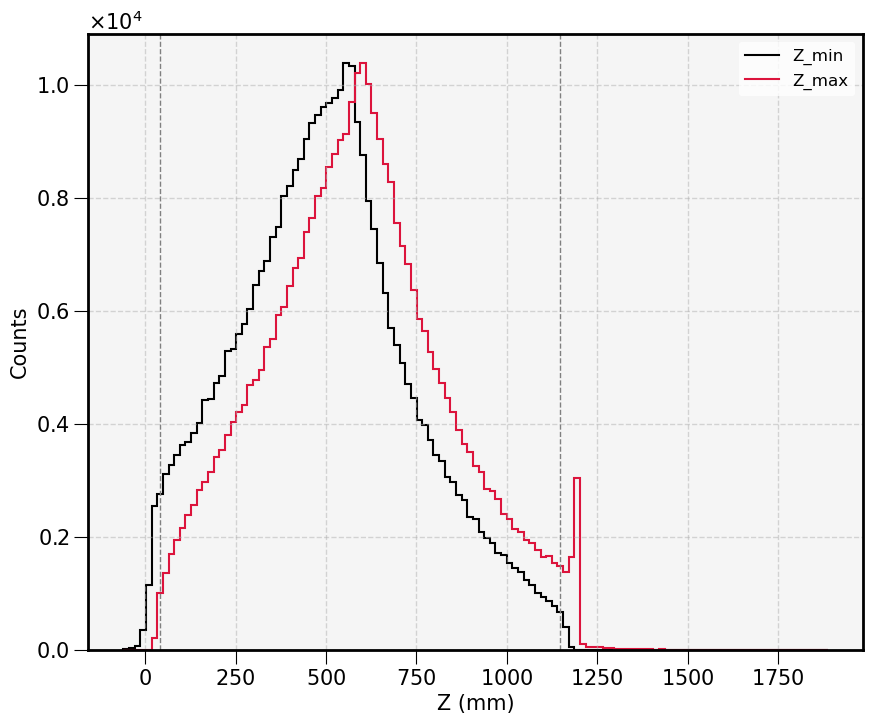

In [4]:
# Global
n_bins = 125

# ----- Define the Binning ----- #
_, Z_edges = np.histogram(event_df['Z_bary'], bins=n_bins)


for i, var in enumerate(['Z_min', 'Z_max']):

        Z_counts, _ = np.histogram(event_df[var], bins=Z_edges)

        # ----- Plotting ----- #
        plt.stairs(Z_counts, Z_edges, label=f'{var}',
                   fill=False, lw=1.5, ec=pt.hist_colors[i % len(pt.hist_colors)])

# Z-limits
plt.axvline(x=Z_LOW, c='grey', ls='--', lw=1.0)
plt.axvline(x=Z_UP, c='grey', ls='--', lw=1.0)
        
# ----- Styling ----- #
plt.xlabel('Z (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper right', fontsize=12)

plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
plt.show()

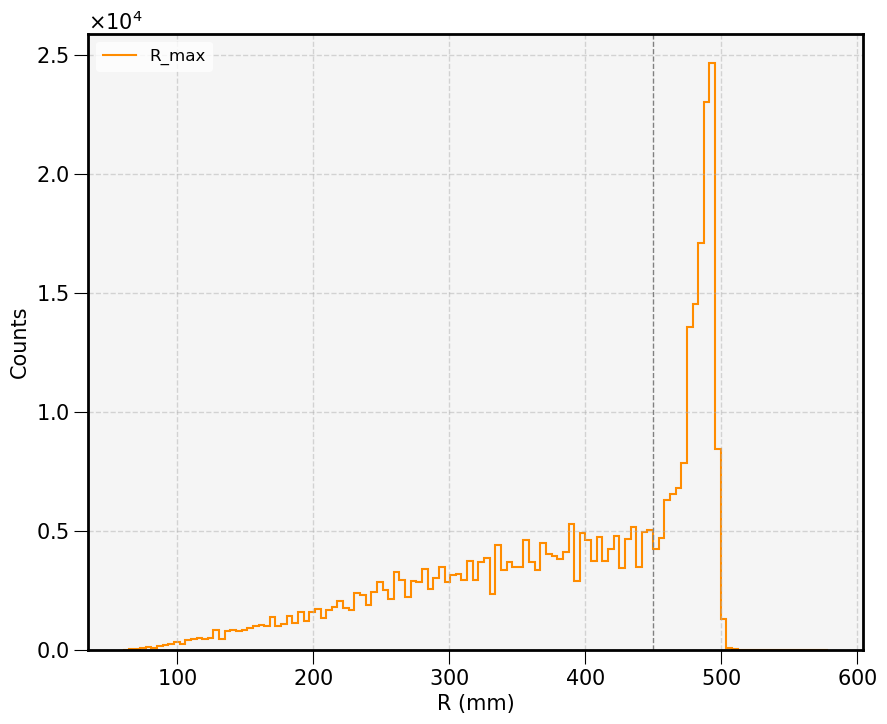

In [5]:
# Global
n_bins = 125

R_counts, R_edges = np.histogram(event_df['R_max'], bins=n_bins)

# ----- Plotting ----- #
plt.stairs(R_counts, R_edges, label='R_max',
           fill=False, lw=1.5, ec=pt.hist_colors[2])

# R-limit
plt.axvline(x=R_UP, c='grey', ls='--', lw=1.0)
        
# ----- Styling ----- #
plt.xlabel('R (mm)')
plt.ylabel('Counts')
plt.legend(loc='upper left', fontsize=12)

plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
plt.show()

# Selection

In [6]:
fidu_mask = (event_df['Z_min'] >= Z_LOW) & (event_df['Z_max'] <= Z_UP) & (event_df['R_max'] <= R_UP)
FIDU_EVT_DF = event_df[fidu_mask]

print(f'----- Fiducial Volume Selection -----')
print(f'Fiducial events = {FIDU_EVT_DF["event"].nunique()} ({FIDU_EVT_DF["event"].nunique() / event_df["event"].nunique():.2%})')

----- Fiducial Volume Selection -----
Fiducial events = 213196 (59.02%)


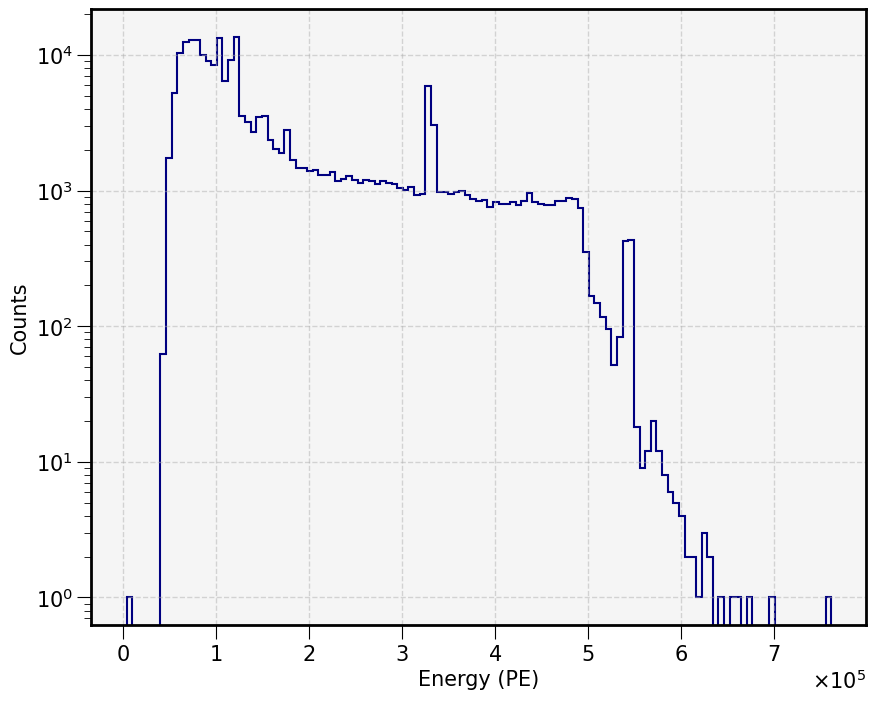

In [7]:
# Global
n_bins = 125

E_counts, E_edges = np.histogram(FIDU_EVT_DF['E_final'], bins=n_bins)

# ----- Plotting ----- #
plt.stairs(E_counts, E_edges,
           fill=False, lw=1.5, ec=pt.hist_colors[5])
        
# ----- Styling ----- #
plt.xlabel('Energy (PE)')
plt.ylabel('Counts')
plt.yscale('log')
plt.ticklabel_format(axis='x', style='sci', scilimits=(5, 5))

plt.grid(True)
plt.gca().set_facecolor("whitesmoke")
plt.show()

# Energy Analysis

## Functions

In [8]:
# --- Fitting Functions --- #
def gaus_with_linear_bg(x, amplitude, mu, sigma, slope, intercept):
    '''
    A Gaussian peak with a sloped, linear background
    '''
    # Failsafe for sigma
    sigma = max(abs(sigma), 1e-9)

    gauss_part = amplitude * np.exp(-(x - mu)**2 / (2 * sigma**2))
    linear_part = slope * x + intercept

    return gauss_part + linear_part

def crystal_ball_with_linear_bg(x, amplitude, mu, sigma, alpha, n, slope, intercept):
    '''
    Crystal Ball function with a linear background.
    '''
    # Failsafes for stability
    n = max(n, 1e-9)
    sigma = max(abs(sigma), 1e-9)
    alpha = max(alpha, 1e-9)

    t = (x - mu) / sigma
    
    # Gaussian part
    gauss = amplitude * np.exp(-0.5 * t**2)
    
    # Power-law tail part
    A = (n / abs(alpha))**n * np.exp(-0.5 * alpha**2)
    B = n / abs(alpha) - abs(alpha)
    tail = amplitude * A * (B - t)**(-n)
    
    # Combine using masks
    cb_shape = np.where(t > -alpha, gauss, tail)
    
    return cb_shape + (slope * x + intercept)

def fit_peak_crystal_ball(data, mu_guess, fit_range, bins='auto'):
    '''
    Fits a Crystal Ball + linear background to a peak.
    '''
    y, bin_edges = np.histogram(data, bins=bins, range=fit_range)
    x = (bin_edges[:-1] + bin_edges[1:]) / 2

    if np.sum(y) < 50: 
        return None, None, (x, y)
    
    # Smart guesses
    slope_guess     = (np.mean(y[-5:]) - np.mean(y[:5])) / (x[-1] - x[0])
    intercept_guess = np.mean(y[:5]) - slope_guess * x[0]
    amplitude_guess = y.max() - (slope_guess * mu_guess + intercept_guess)
    sigma_guess = (fit_range[1] - fit_range[0]) / 10
    
    # Crystal ball specific guesses: alpha controls where tail starts, n controls shape
    alpha_guess = 1.0 
    n_guess = 2.0
    
    p0 = [amplitude_guess, mu_guess, sigma_guess, alpha_guess, n_guess, slope_guess, intercept_guess]

    try:
        popt, pcov = curve_fit(crystal_ball_with_linear_bg, x, y, p0=p0, sigma=np.sqrt(np.maximum(y, 1)))
        return popt, pcov, (x, y)
    except (RuntimeError, ValueError) as e:
        print(f"   Fit failed for peak near {mu_guess:.1f}. Reason: {e}")
        return None, None, (x, y)

# --- Calibration Pipeline --- #
def calibrate_pes_to_MeV_and_get_resolution(
                                                event_energies_df: pd.DataFrame,    # Expects energy in PE
                                                known_peaks_pes: dict               # Dictionary with guesses/ranges in PE
):
    """
    A full pipeline that:
    1. Fits peaks in the uncalibrated 'pes' spectrum.
    2. Determines the linear pes -> MeV calibration.
    3. Applies the calibration.
    4. Re-fits the peaks in the calibrated MeV spectrum to find the resolution.
    """
    print(f"\n{'='*20} Running PE → MeV Calibration {'='*20}")
    initial_energies_pes = event_energies_df['E_final']
    
    # ----- STAGE 01: Initial Fits in PE ----- #
    print("\nSTAGE 01: Fitting uncalibrated peaks to find positions in PE...")
    fig_init, axes_init = plt.subplots(int(np.ceil(len(known_peaks_pes)/2)), 2, figsize=(16, 5*np.ceil(len(known_peaks_pes)/2)))
    axes_init = axes_init.flatten()
    plt.suptitle(f'Initial Peak Fits (in PE)', fontsize=25, y=0.94)

    # Fitting
    initial_fit_results = []
    for i, (peak_name, props) in enumerate(known_peaks_pes.items()):
        ax = axes_init[i]
        popt, pcov, hist_data = fit_peak_crystal_ball(initial_energies_pes, props['guess'], props['range'], bins=props.get('bins', 'auto'))
        
        # Plotting
        # Data
        ax.step(hist_data[0], hist_data[1], where='mid', label='Data')
        if popt is not None:
            # Fit
            fit_x = np.linspace(props['range'][0], props['range'][1], 300)
            ax.plot(fit_x, crystal_ball_with_linear_bg(fit_x, *popt), 'r-', label='Fit')
            # Results
            mu, mu_err = popt[1], np.sqrt(pcov[1, 1])
            ax.text(0.025, 0.95, f'μ = ({mu:.1f} ± {mu_err:.1f}) PE', transform=ax.transAxes, va='top')
            initial_fit_results.append({'name': peak_name, 'real_E_MeV': props['real_MeV'], 'measured_E_pes': mu, 'measured_E_err_pes': mu_err})
        # Styling
        ax.set_title(f'→ {peak_name}'); ax.set_xlabel('Measured Energy (PE)'); ax.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # ----- STAGE 02: Energy Scale (MeV vs. PE) ----- #
    fit_df = pd.DataFrame(initial_fit_results)
    if len(fit_df) < 2:
        print("Not enough successful fits to perform calibration. Aborting."); return None
    
    # Fit: Nominal Energy (MeV) = m * Measured Energy (PE) + n
    calib_fit = linregress(fit_df['measured_E_pes'], fit_df['real_E_MeV'])      # From here we can extract linear fit information
    m_calib, b_calib = calib_fit.slope, calib_fit.intercept
    calib_results = [{'m_cv': m_calib, 'm_err': calib_fit.stderr, 'b_cv': b_calib, 'b_err': calib_fit.intercept_stderr, 'r_value': calib_fit.rvalue}]
    print(f"\nStage 02: Calibration → E_MeV = {m_calib:.2e} * E_PE + {b_calib:.4f}")

    # Plotting
    fig_calib, ax_calib = plt.subplots(figsize=(6, 5))
    # Data
    ax_calib.errorbar(fit_df['measured_E_pes'], fit_df['real_E_MeV'], xerr=fit_df['measured_E_err_pes'], fmt='o', capsize=3, label='Fitted Peaks')
    # Fit
    x_fit = np.array([0, fit_df['measured_E_pes'].max() * 1.1]); y_fit = m_calib * x_fit + b_calib
    ax_calib.plot(x_fit, y_fit, 'b--', label=f'Fit')
    ax_calib.set_xlabel('Measured Peak Energy (PE)'); ax_calib.set_ylabel('Real Peak Energy (MeV)'); ax_calib.legend(); ax_calib.grid(True)
    plt.show()

    # ----- STAGE 03: Apply Calibration ----- #
    print("\nStage 03: Applying calibration, going from PE to MeV...")
    calibrated_energies_MeV = m_calib * initial_energies_pes + b_calib
    
    # ----- STAGE 04: Final Fits in MeV ----- #
    print("\nStage 4: Computing final energy resolution...")
    fig_final, axes_final = plt.subplots(int(np.ceil(len(known_peaks_pes)/2)), 2, figsize=(16, 5*np.ceil(len(known_peaks_pes)/2)))
    axes_final = axes_final.flatten()
    fig_final.suptitle(f'Final Resolution Fits (in MeV)', fontsize=25, y=0.94)

    # Fitting
    final_resolution_results = []
    for i, (peak_name, props) in enumerate(known_peaks_pes.items()):
        ax = axes_final[i]
        real_E = props['real_MeV']
        # Define fit range in calibrated MeV units
        calib_range = (real_E - 0.05, real_E + 0.05)
        popt, pcov, hist_data = fit_peak_crystal_ball(calibrated_energies_MeV, real_E, calib_range, bins=props.get('bins', 'auto'))
        
        # Plotting
        # Data
        ax.step(hist_data[0], hist_data[1], where='mid', label='Data')
        if popt is not None:
            # Fit
            fit_x = np.linspace(calib_range[0], calib_range[1], 300)
            ax.plot(fit_x, crystal_ball_with_linear_bg(fit_x, *popt), 'r-', label='Fit')
            # Results
            mu, sigma = popt[1], abs(popt[2])
            mu_err, sigma_err = np.sqrt(pcov[1, 1]), np.sqrt(pcov[2, 2])
            res_cv  = 2.355 * sigma / mu * 100
            res_err = res_cv * np.sqrt((sigma_err/sigma)**2 + (mu_err/mu)**2) if sigma > 0 else np.nan
            ax.text(0.025, 0.95, f'μ = ({mu:.4f} ± {mu_err:.4f}) MeV\nR(%) = {res_cv:.2f} ± {res_err:.2f}', transform=ax.transAxes, va='top')
            final_resolution_results.append({'peak': peak_name, 'resolution_(FWHM)': res_cv, 'resolution_error': res_err})
        # Styling         
        ax.set_title(f'→ {peak_name}'); ax.set_xlabel('Calibrated Energy (MeV)'); ax.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    return pd.DataFrame(calib_results), pd.DataFrame(final_resolution_results)

## Execution


==================== Running PE → MeV Calibration ====================

STAGE 01: Fitting uncalibrated peaks to find positions in PE...


/tmp/ccortesp/ipykernel_2433338/1220371936.py:31: RuntimeWarning: invalid value encountered in power
  tail = amplitude * A * (B - t)**(-n)
/tmp/ccortesp/ipykernel_2433338/1220371936.py:31: RuntimeWarning: invalid value encountered in power
  tail = amplitude * A * (B - t)**(-n)
/tmp/ccortesp/ipykernel_2433338/1220371936.py:31: RuntimeWarning: invalid value encountered in power
  tail = amplitude * A * (B - t)**(-n)
/tmp/ccortesp/ipykernel_2433338/1220371936.py:29: RuntimeWarning: overflow encountered in double_scalars
  A = (n / abs(alpha))**n * np.exp(-0.5 * alpha**2)
/tmp/ccortesp/ipykernel_2433338/1220371936.py:31: RuntimeWarning: invalid value encountered in multiply
  tail = amplitude * A * (B - t)**(-n)
/tmp/ccortesp/ipykernel_2433338/1220371936.py:31: RuntimeWarning: invalid value encountered in power
  tail = amplitude * A * (B - t)**(-n)
/tmp/ccortesp/ipykernel_2433338/1220371936.py:29: RuntimeWarning: overflow encountered in double_scalars
  A = (n / abs(alpha))**n * np.exp(

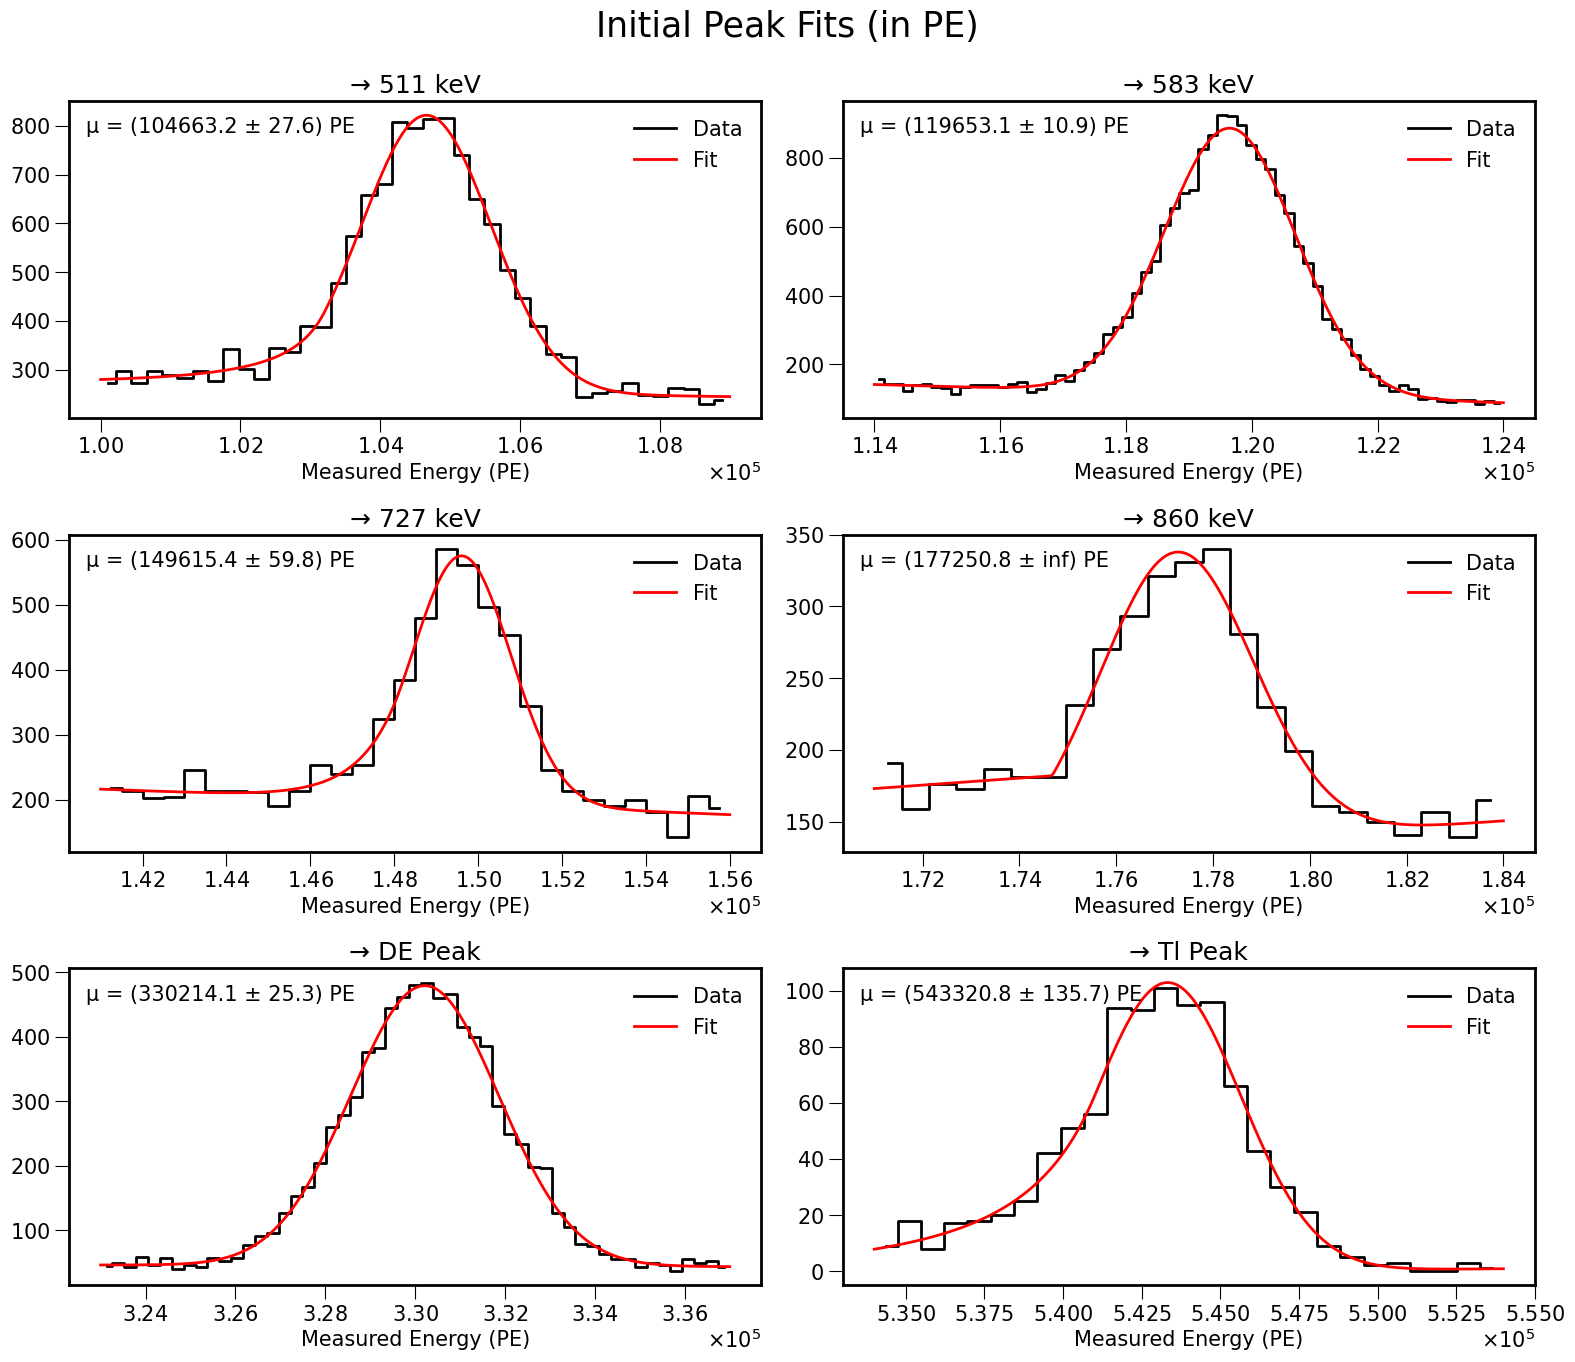


Stage 02: Calibration → E_MeV = 4.80e-06 * E_PE + 0.0094


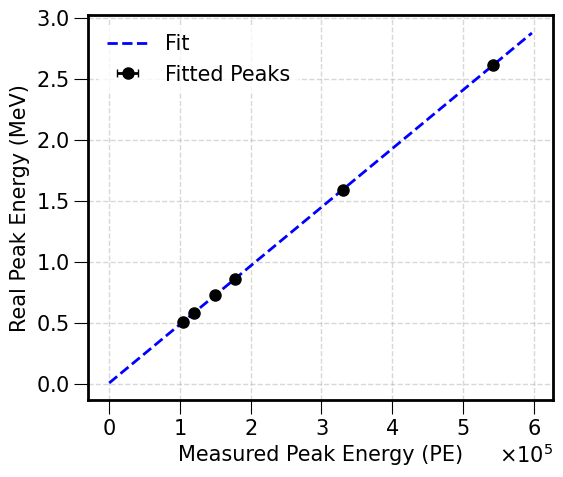


Stage 03: Applying calibration, going from PE to MeV...

Stage 4: Computing final energy resolution...


/tmp/ccortesp/ipykernel_2433338/1220371936.py:31: RuntimeWarning: invalid value encountered in power
  tail = amplitude * A * (B - t)**(-n)
/lhome/ific/c/ccortesp/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ccortesp/ipykernel_2433338/1220371936.py:31: RuntimeWarning: invalid value encountered in power
  tail = amplitude * A * (B - t)**(-n)
/tmp/ccortesp/ipykernel_2433338/1220371936.py:31: RuntimeWarning: invalid value encountered in power
  tail = amplitude * A * (B - t)**(-n)
/lhome/ific/c/ccortesp/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ccortesp/ipykernel_2433338/1220371936.py:31: RuntimeWarning: invalid value encountered in power
  tail = ampl

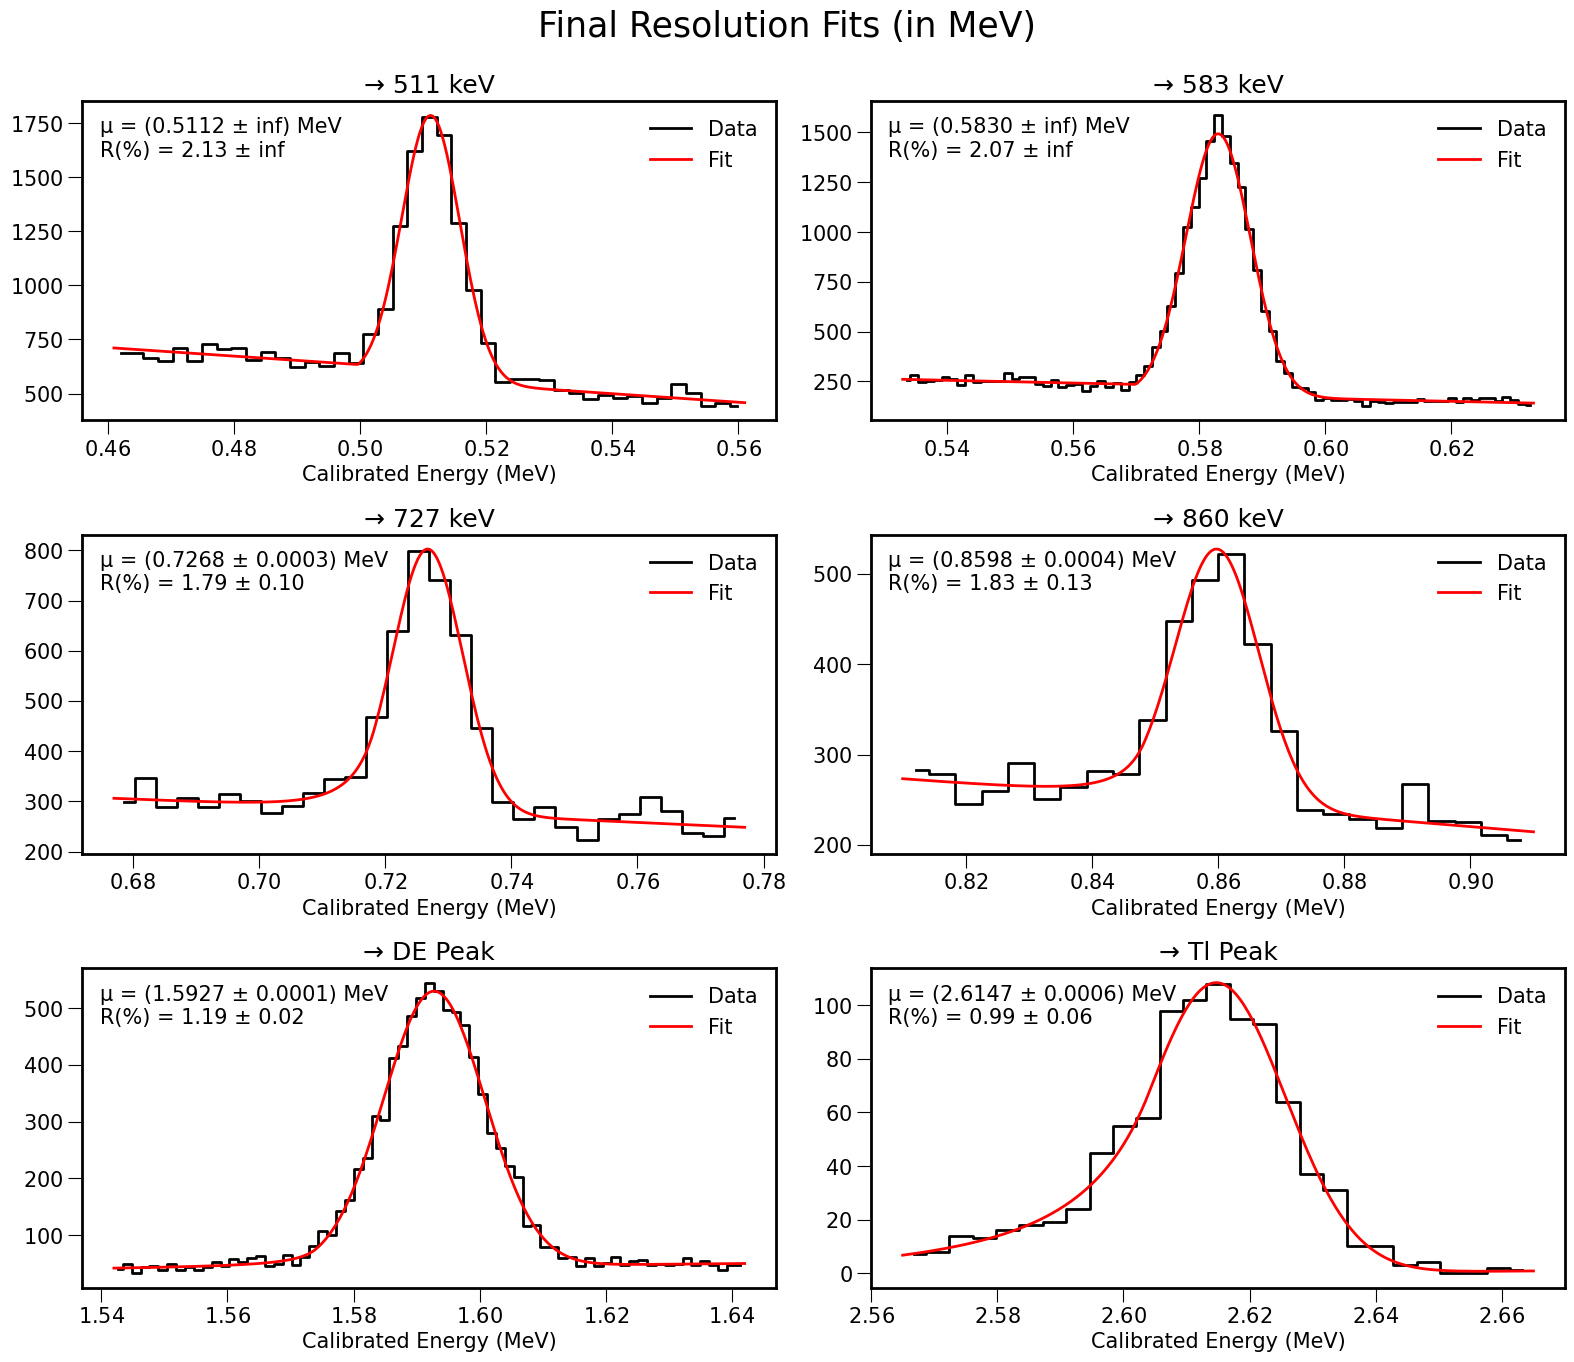


----- Final Summary -----
       m_cv         m_err      b_cv     b_err  r_value
0  0.000005  1.511362e-09  0.009355  0.000429      1.0
      peak  resolution_(FWHM)  resolution_error
0  511 keV           2.125188               inf
1  583 keV           2.069072               inf
2  727 keV           1.794203          0.099490
3  860 keV           1.826758          0.134383
4  DE Peak           1.190879          0.021203
5  Tl Peak           0.988825          0.061765


In [9]:
calibration_table, resolution_table = calibrate_pes_to_MeV_and_get_resolution(
                                                                                    event_energies_df=FIDU_EVT_DF,
                                                                                    known_peaks_pes=KNOWN_PEAKS_PES
                                                                             )

print("\n----- Final Summary -----")
print(calibration_table)
print(resolution_table)